In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torch.utils.data import random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import random
from PIL import Image
import os
import shutil
from google.colab import drive
import zipfile
import itertools
from torch.optim import SGD, Adam, RMSprop
from copy import deepcopy

## EDA for the Dataset

## Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Unzipping the dataset

In [4]:
import zipfile
import os

# Path to the zip file
zip_data_set = '/content/drive/MyDrive/DeepLearning/lfwa.zip'

# Destination folder
destination_folder = '/content'

# Ensure the destination folder exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Unzip the dataset
with zipfile.ZipFile(zip_data_set, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Dataset successfully extracted to {destination_folder}")

Dataset successfully extracted to /content


In [5]:
import shutil
import os

# Define the source and destination paths
source_path_test = '/content/drive/MyDrive/DeepLearning/pairsDevTest.txt'
source_path_train = '/content/drive/MyDrive/DeepLearning/pairsDevTrain.txt'
destination_folder = '/content/lfw'

# Ensure the destination directory exists
os.makedirs(destination_folder, exist_ok=True)

# Define separate destination paths for test and train files
destination_path_test = os.path.join(destination_folder, 'pairsDevTest.txt')
destination_path_train = os.path.join(destination_folder, 'pairsDevTrain.txt')

# Copy the files
shutil.copy(source_path_test, destination_path_test)
shutil.copy(source_path_train, destination_path_train)

print(f"Test file copied to {destination_path_test}")
print(f"Train file copied to {destination_path_train}")



Test file copied to /content/lfw/pairsDevTest.txt
Train file copied to /content/lfw/pairsDevTrain.txt


Splitting Train and Test

In [6]:
import os
import shutil

# Paths
data_folder = '/content/lfw2/lfw2'  # Root folder of the dataset (unzipped)
train_txt_path = '/content/lfw/pairsDevTrain.txt'
test_txt_path = '/content/lfw/pairsDevTest.txt'
train_dir = '/content/lfw2/train'
test_dir = '/content/lfw2/test'

# Ensure train and test directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def process_file(txt_path, target_dir, lfw_folder):
    """
    Process the given text file and move the specified images to the target directory,
    handling both positive and negative pairs dynamically.

    txt_path: Path to the text file containing train/test pairs.
    target_dir: Directory where processed images will be stored.
    lfw_folder: The folder containing the original dataset images.
    """
    with open(txt_path, 'r') as f:
        lines = f.readlines()

    # Skip the first line (indicates the number of pairs)
    pairs = lines[1:]

    for line in pairs:
        parts = line.strip().split()

        if len(parts) == 3:
            # Positive pair: [person img1 img2]
            person = parts[0]
            img1_idx = int(parts[1])
            img2_idx = int(parts[2])

            # Paths to the images in the original dataset
            img1_path = os.path.join(lfw_folder, person, f"{person}_{img1_idx:04d}.jpg")
            img2_path = os.path.join(lfw_folder, person, f"{person}_{img2_idx:04d}.jpg")

            # Target paths for the train/test directories
            target_person_dir = os.path.join(target_dir, person)
            os.makedirs(target_person_dir, exist_ok=True)

            target_img1 = os.path.join(target_person_dir, f"{person}_{img1_idx:04d}.jpg")
            target_img2 = os.path.join(target_person_dir, f"{person}_{img2_idx:04d}.jpg")

            # Move the files if they exist
            if os.path.exists(img1_path):
                shutil.copy(img1_path, target_img1)
            else:
                print(f"Warning: {img1_path} does not exist!")

            if os.path.exists(img2_path):
                shutil.copy(img2_path, target_img2)
            else:
                print(f"Warning: {img2_path} does not exist!")

        elif len(parts) == 4:
            # Negative pair: [person1 img1 person2 img2]
            person1 = parts[0]
            img1_idx = int(parts[1])
            person2 = parts[2]
            img2_idx = int(parts[3])

            # Paths to the images in the original dataset
            img1_path = os.path.join(lfw_folder, person1, f"{person1}_{img1_idx:04d}.jpg")
            img2_path = os.path.join(lfw_folder, person2, f"{person2}_{img2_idx:04d}.jpg")

            # Target paths for the train/test directories
            target_person1_dir = os.path.join(target_dir, person1)
            target_person2_dir = os.path.join(target_dir, person2)
            os.makedirs(target_person1_dir, exist_ok=True)
            os.makedirs(target_person2_dir, exist_ok=True)

            target_img1 = os.path.join(target_person1_dir, f"{person1}_{img1_idx:04d}.jpg")
            target_img2 = os.path.join(target_person2_dir, f"{person2}_{img2_idx:04d}.jpg")

            # Move the files if they exist
            if os.path.exists(img1_path):
                shutil.copy(img1_path, target_img1)
            else:
                print(f"Warning: {img1_path} does not exist!")

            if os.path.exists(img2_path):
                shutil.copy(img2_path, target_img2)
            else:
                print(f"Warning: {img2_path} does not exist!")

        else:
            # Handle invalid cases
            print(f"Invalid line format: {line.strip()}")

    print(f"Processed {txt_path} and moved files to {target_dir}")


# Process train and test text files
process_file(train_txt_path, train_dir, data_folder)
process_file(test_txt_path, test_dir, data_folder)


Processed /content/lfw/pairsDevTrain.txt and moved files to /content/lfw2/train
Processed /content/lfw/pairsDevTest.txt and moved files to /content/lfw2/test


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class SiameseLFWDataset(Dataset):
    def __init__(self, txt_file, image_folder, transform=None):
        """
        Custom Dataset for the Siamese network.

        txt_file: Path to the train/test txt file.
        image_folder: Folder containing the images (organized by subdirectories).
        transform: Transformations to apply to the images.
        """
        self.image_folder = image_folder
        self.transform = transform
        self.pairs = []  # List to store (img1, img2, label)

        with open(txt_file, 'r') as f:
            lines = f.readlines()

        # Skip the first line (indicates number of pairs)
        for line in lines[1:]:
            parts = line.strip().split()

            if len(parts) == 3:
                # Positive pair: [person img1 img2]
                person = parts[0]
                img1_path = os.path.join(image_folder, person, f"{person}_{int(parts[1]):04d}.jpg")
                img2_path = os.path.join(image_folder, person, f"{person}_{int(parts[2]):04d}.jpg")
                self.pairs.append((img1_path, img2_path, 1))  # Label 1 for positive pairs

            elif len(parts) == 4:
                # Negative pair: [person1 img1 person2 img2]
                person1 = parts[0]
                person2 = parts[2]
                img1_path = os.path.join(image_folder, person1, f"{person1}_{int(parts[1]):04d}.jpg")
                img2_path = os.path.join(image_folder, person2, f"{person2}_{int(parts[3]):04d}.jpg")
                self.pairs.append((img1_path, img2_path, 0))  # Label 0 for negative pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]

        # Load images
        img1 = Image.open(img1_path).convert("L")  # Convert to grayscale
        img2 = Image.open(img2_path).convert("L")

        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label


In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Paths
train_txt_path = '/content/lfw/pairsDevTrain.txt'
test_txt_path = '/content/lfw/pairsDevTest.txt'
train_dir = '/content/lfw2/train'
test_dir = '/content/lfw2/test'

# Define transformations (resize only, no normalization)
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Uncomment if images are grayscale and need normalization
])

# Create datasets
train_dataset = SiameseLFWDataset(train_txt_path, train_dir, transform=transform)
test_dataset = SiameseLFWDataset(test_txt_path, test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


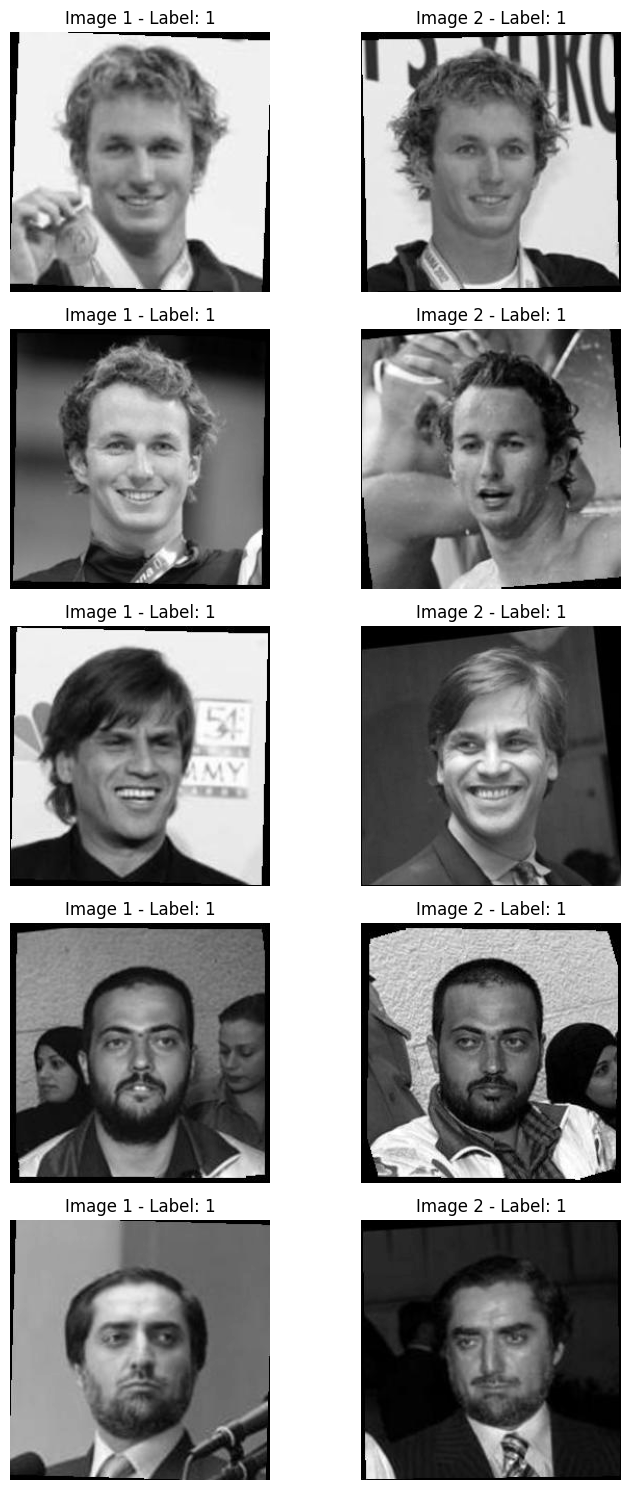

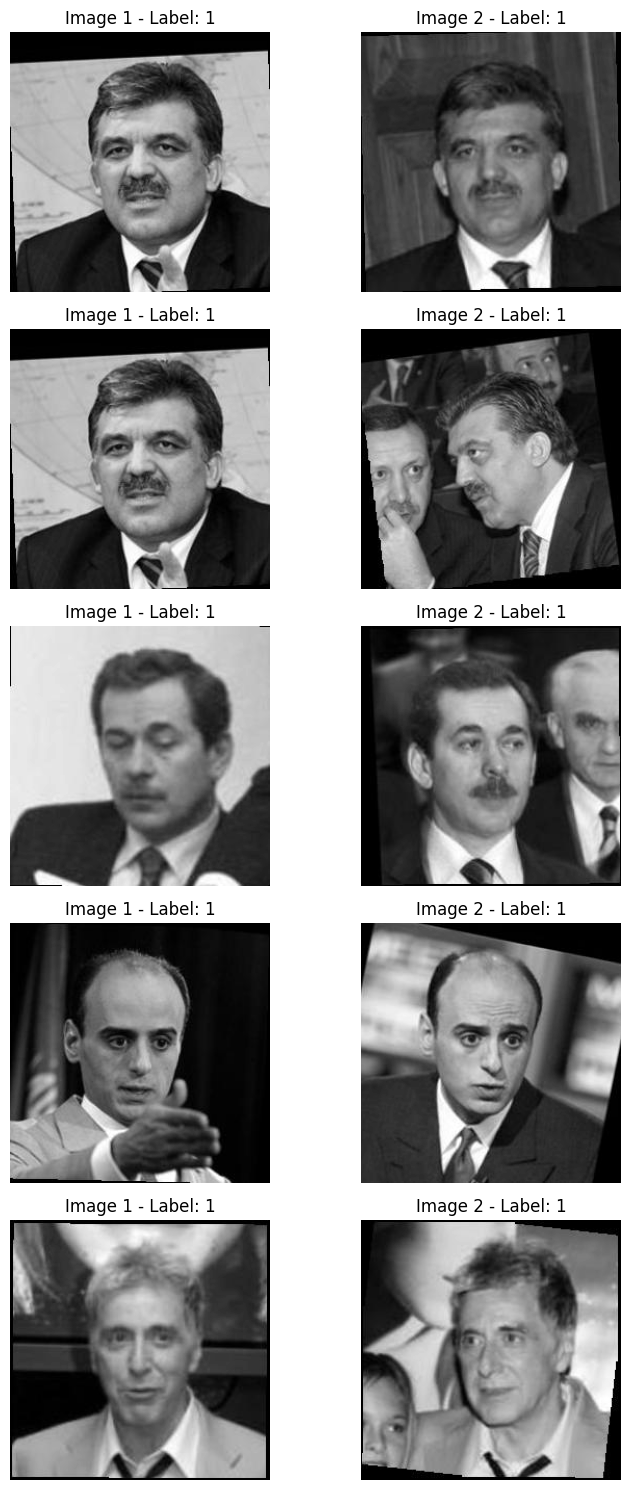

In [9]:
import matplotlib.pyplot as plt

def visualize_dataloader(dataset, num_samples=5):
    """
    Visualize the first `num_samples` image pairs from the dataset.

    dataset: The dataset to visualize (e.g., train_dataset).
    num_samples: Number of pairs to visualize.
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))
    axes = axes if num_samples > 1 else [axes]  # Handle single sample case

    for i in range(num_samples):
        img1, img2, label = dataset[i]  # Get the i-th pair
        img1 = img1.permute(1, 2, 0).numpy()  # Convert to (H, W, C) for plotting
        img2 = img2.permute(1, 2, 0).numpy()

        # Plot first image
        axes[i][0].imshow(img1, cmap="gray")
        axes[i][0].set_title(f"Image 1 - Label: {label}")
        axes[i][0].axis("off")

        # Plot second image
        axes[i][1].imshow(img2, cmap="gray")
        axes[i][1].set_title(f"Image 2 - Label: {label}")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize a few samples from the training dataset
visualize_dataloader(train_dataset, num_samples=5)
visualize_dataloader(test_dataset, num_samples=5)


## EDA for the Dataset

In [10]:
def dataset_statistics(dataset):
    """
    Compute and print the size and class distribution of the dataset.

    dataset: Instance of a dataset (e.g., train_dataset, test_dataset)
    """
    total_examples = len(dataset)
    class_counts = {0: 0, 1: 0}  # Initialize class counts for labels 0 and 1

    for _, _, label in dataset:
        class_counts[label] += 1

    print(f"Total Examples: {total_examples}")
    print(f"Class Distribution: {class_counts}")
    print(f"Positive Pairs: {class_counts[1]}")
    print(f"Negative Pairs: {class_counts[0]}")

# Analyze train and test datasets
print("Train Dataset Statistics:")
dataset_statistics(train_dataset)

print("\nTest Dataset Statistics:")
dataset_statistics(test_dataset)


Train Dataset Statistics:
Total Examples: 2200
Class Distribution: {0: 1100, 1: 1100}
Positive Pairs: 1100
Negative Pairs: 1100

Test Dataset Statistics:
Total Examples: 1000
Class Distribution: {0: 500, 1: 500}
Positive Pairs: 500
Negative Pairs: 500


In [11]:
# Load the image
image_path = "/content/lfw2/test/AJ_Lamas/AJ_Lamas_0001.jpg"
image = Image.open(image_path)

# Get the size of the image
image_size = image.size  # (width, height)
image_mode = image.mode  # "L" for grayscale, "RGB" for color

print(f"Image size: {image_size}")
print(f"Image mode: {image_mode}")

Image size: (250, 250)
Image mode: L


Our Images are 250x250 and Grey-scale - meaning one channel, So our Input will be 1 @ 250x250

## Model Architecture

In our Model the Input is a 250X250 Grey Scale

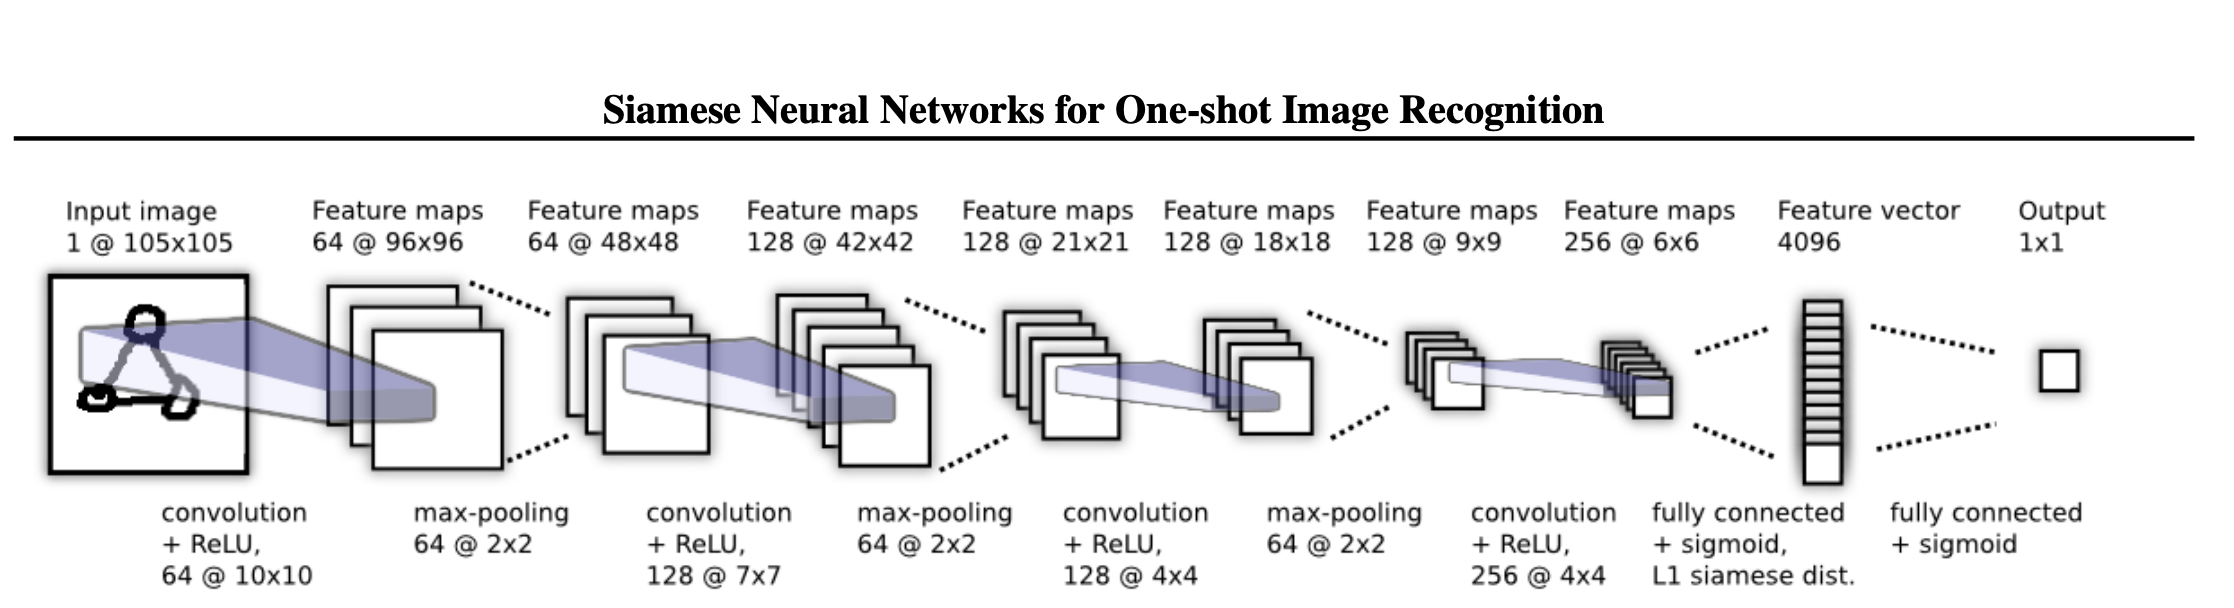

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from copy import deepcopy

class PaperFeatureExtractor(nn.Module):
    def __init__(self,dropout=0.3):
        super(PaperFeatureExtractor, self).__init__()
        self.dropout = dropout
        # Convolution Layer 1: Input: 1x250x250 -> Output: 64x96x96
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=10,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout)
        )

        # Max Pooling 1: Output: 64x48x48
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Layer 2: Output: 128x42x42
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout)
        )

        # Max Pooling 2: Output: 128x21x21
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Layer 3: Output: 128x18x18
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout)
        )

        # Max Pooling 3: Output: 128x9x9
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Layer 4: Output: 256x6x6
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7),
            nn.BatchNorm2d(256),       # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout)
        )

        # After this: Flatten (256*6*6=9216) -> 4096 with Sigmoid
        self.fc = nn.Sequential(
            nn.Linear(256*6*6, 4096),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                # Kaiming He initialization for ReLU
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
            elif isinstance(module, nn.Linear):
                # Xavier Glorot initialization for linear layers
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0.0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
      # Making an 4096 Embedding of the Image
        x = self.conv1(x)    # 64x96x96
        x = self.pool1(x)    # 64x48x48
        x = self.conv2(x)    # 128x42x42
        x = self.pool2(x)    # 128x21x21
        x = self.conv3(x)    # 128x18x18
        x = self.pool3(x)    # 128x9x9
        x = self.conv4(x)    # 256x6x6
        x = x.view(x.size(0), -1) # Flatten to 9216
        x = self.fc(x)       # 4096
        return x

class PaperSiameseNetwork(nn.Module):
    def __init__(self):
        super(PaperSiameseNetwork, self).__init__()
        self.feature_extractor = PaperFeatureExtractor()
        self.classifier = nn.Linear(4096, 1)
        nn.init.normal_(self.classifier.weight, mean=0.0, std=0.2)
        nn.init.normal_(self.classifier.bias, mean=0.5, std=0.01)

    def forward(self, x1, x2):
        f1 = self.feature_extractor(x1)
        f2 = self.feature_extractor(x2)
        l1_dist = torch.abs(f1 - f2)
        out = torch.sigmoid(self.classifier(l1_dist))
        return out



In [38]:
import torch
import torch.nn as nn

class PaperFeatureExtractor_1024_Output(nn.Module):
    def __init__(self, dropout_flag=True):  # Add dropout_flag with default as True
        super(PaperFeatureExtractor_1024_Output, self).__init__()

        # Define dropout layer
        self.dropout_flag = dropout_flag
        self.dropout = nn.Dropout(p=0.3) if dropout_flag else nn.Identity()

        # Convolution Layer 1: Input: 1x250x250 -> Output: 64x96x96
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=10, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            self.dropout  # Use conditional dropout
        )

        # Max Pooling 1: Output: 64x48x48
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Layer 2: Output: 128x42x42
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self.dropout  # Use conditional dropout
        )

        # Max Pooling 2: Output: 128x21x21
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Layer 3: Output: 128x18x18
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self.dropout  # Use conditional dropout
        )

        # Max Pooling 3: Output: 128x9x9
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Layer 4: Output: 256x6x6
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7),
            nn.BatchNorm2d(256),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            self.dropout  # Use conditional dropout
        )

                # After this: Flatten (256*6*6=9216) -> 4096 with Sigmoid
        self.fc = nn.Sequential(
            nn.Linear(256*6*6, 1024),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                # Kaiming He initialization for ReLU
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
            elif isinstance(module, nn.Linear):
                # Xavier Glorot initialization for linear layers
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0.0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1.0)
                nn.init.constant_(module.bias, 0.0)

    def set_dropout(self, dropout_flag):
      # Set to True in trainig, False for testing.
      self.dropout_flag = dropout_flag
      self.dropout = nn.Dropout(p=0.3) if dropout_flag else nn.Identity()
      for module in [self.conv1, self.conv2, self.conv3, self.conv4]:
          for layer in module:
              if isinstance(layer, nn.Dropout):
                layer = self.dropout

    def forward(self, x):
      # Making an 4096 Embedding of the Image
        x = self.conv1(x)    # 64x96x96
        x = self.pool1(x)    # 64x48x48
        x = self.conv2(x)    # 128x42x42
        x = self.pool2(x)    # 128x21x21
        x = self.conv3(x)    # 128x18x18
        x = self.pool3(x)    # 128x9x9
        x = self.conv4(x)    # 256x6x6
        x = x.view(x.size(0), -1) # Flatten to 9216
        x = self.fc(x)       # 4096
        return x

In [37]:
class Paper_SiameseNetwork_1024_Output(nn.Module):
    def __init__(self):
        super(Paper_SiameseNetwork_1024_Output, self).__init__()
        self.feature_extractor = PaperFeatureExtractor_1024_Output()
        self.classifier = nn.Linear(1024, 1)
        nn.init.normal_(self.classifier.weight, mean=0.0, std=0.2)
        nn.init.normal_(self.classifier.bias, mean=0.5, std=0.01)

    def forward(self, x1, x2):
        f1 = self.feature_extractor(x1)
        f2 = self.feature_extractor(x2)
        l1_dist = torch.abs(f1 - f2)
        out = torch.sigmoid(self.classifier(l1_dist))
        return out



### Trying a Simplified Network

In [13]:
import torch
import torch.nn as nn

class SimplifiedFeatureExtractor(nn.Module):
    def __init__(self, dropout_flag=True):
        super(SimplifiedFeatureExtractor, self).__init__()

        # Dropout configuration
        self.dropout_flag = dropout_flag
        self.dropout = nn.Dropout(p=0.3) if dropout_flag else nn.Identity()

        # Convolution Block 1: Input: 1x250x250 -> Output: 32x62x62
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            self.dropout
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Block 2: Output: 64x15x15
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            self.dropout
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Block 3: Output: 128x4x4
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self.dropout
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer: Flatten -> Output 512
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024),  # Flattened size = 128 * 4 * 4 = 2048
            nn.ReLU(inplace=True),       # Optional ReLU
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0.0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = self.conv1(x)    # 32x62x62
        x = self.pool1(x)    # 32x62x62
        x = self.conv2(x)    # 64x15x15
        x = self.pool2(x)    # 64x15x15
        x = self.conv3(x)    # 128x4x4
        x = self.pool3(x)    # 128x4x4
        x = x.view(x.size(0), -1)  # Flatten to 128 * 4 * 4 = 2048
        x = self.fc(x)       # Output 1024
        return x

class SimplifiedSiameseNetwork(nn.Module):
    def __init__(self):
        super(SimplifiedSiameseNetwork, self).__init__()
        self.feature_extractor = SimplifiedFeatureExtractor()
        self.classifier = nn.Linear(1024, 1)
        nn.init.normal_(self.classifier.weight, mean=0.0, std=0.2)
        nn.init.normal_(self.classifier.bias, mean=0.5, std=0.01)

    def forward(self, x1, x2):
        f1 = self.feature_extractor(x1)
        f2 = self.feature_extractor(x2)
        l1_dist = torch.abs(f1 - f2)  # L1 Distance
        out = torch.sigmoid(self.classifier(l1_dist))
        return out


## Training and Evaluation

##HyperParameters

In [14]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.001
MAX_EPOCHS = 50
EARLY_STOP_PATIENCE = 20
SEED = 42

###Loading the Data

In [15]:
# Paths
train_txt_path = '/content/lfw/pairsDevTrain.txt'
test_txt_path = '/content/lfw/pairsDevTest.txt'
train_dir = '/content/lfw2/train'
test_dir = '/content/lfw2/test'

# Define transformations (resize only, no normalization)
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomHorizontalFlip(),   # Random horizontal flip
    transforms.RandomRotation(10),       # Random rotation within ±10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])
# Create datasets
train_dataset = SiameseLFWDataset(train_txt_path, train_dir, transform=transform)
test_dataset = SiameseLFWDataset(test_txt_path, test_dir, transform=transform)

# Set random seed for reproducibility
torch.manual_seed(SEED)

# Calculate lengths for train and validation splits
train_len = int(len(train_dataset) * (1 - VALIDATION_SPLIT))
val_len = len(train_dataset) - train_len

# Perform the split with the random seed
train_subset, val_subset = random_split(train_dataset, [train_len, val_len])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,pin_memory=True)

# Print dataset sizes
print(f"Train Dataset Size: {len(train_subset)}")
print(f"Validation Dataset Size: {len(val_subset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Train Dataset Size: 1760
Validation Dataset Size: 440
Test Dataset Size: 1000


### Training

In [16]:
def evaluate_oneshot(model, val_loader, device):
    """
    Evaluate the model on the validation dataset.
    This function computes the one-shot classification error.
    """
    model.eval()
    val_error = 0.0
    with torch.no_grad():
        for x1, x2, y in val_loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            out = model(x1, x2)
            y = y.float().unsqueeze(1)  # Ensure shape [batch_size, 1]
            val_error += F.binary_cross_entropy(out, y).item()
    val_error /= len(val_loader)
    return val_error

def train_model(model, train_loader, val_loader,
                lr=0.01, momentum=0.9, weight_decay=0.0005,
                max_epochs=200, early_stop_patience=20,device='cpu'):
    """
    Train the Siamese network with the specified DataLoader objects.

    - Starts LR at `lr`, decays by 0.99 each epoch.
    - Momentum starts at 0.5 and linearly increases to `momentum` by the end of training.
    - Uses binary cross entropy loss.
    - Stops early if no improvement in validation after `early_stop_patience` epochs.
    """
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=weight_decay)
    best_val_error = float('inf')
    best_model = None
    epochs_no_improve = 0

    # Training loop
    for epoch in range(max_epochs):
        # Decay LR by 1%
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.99

        # Linearly increase momentum from 0.5 to target momentum
        new_momentum = 0.5 + (momentum - 0.5) * (epoch / max_epochs)
        for param_group in optimizer.param_groups:
            param_group['momentum'] = new_momentum

        # Training phase
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)
        for batch_idx, (x1, x2, y) in enumerate(train_loader):
            # Move data to the specified device
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x1, x2)
            y = y.float().unsqueeze(1)  # Ensure shape [batch_size, 1]
            loss = F.binary_cross_entropy(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # # Print progress for the current epoch
            # if (batch_idx + 1) % 10 == 0 or batch_idx == total_batches - 1:
            #     print(f"Epoch {epoch+1} | Batch {batch_idx+1}/{total_batches} | Loss: {loss.item():.4f}")

        # Calculate average loss for the epoch
        avg_train_loss = running_loss / total_batches

        # Validation phase
        val_error = evaluate_oneshot(model, val_loader,device)

        # Early stopping check
        if val_error < best_val_error:
            best_val_error = val_error
            best_model = deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

        print(f"Epoch [{epoch+1}/{max_epochs}] - Avg Loss: {avg_train_loss:.4f}, Val Error: {val_error:.4f}, LR: {optimizer.param_groups[0]['lr']:.5f}, Momentum: {optimizer.param_groups[0]['momentum']:.4f}")

    # Load the best model (if early stopping was triggered)
    if best_model is not None:
        model.load_state_dict(best_model)

    return model





In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_oneshot_test(model, test_loader, device):
    """
    Evaluate the model on the test dataset.
    This function computes the one-shot classification error and ROC-AUC score,
    and plots the ROC curve.
    """
    model.eval()
    test_error = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for x1, x2, y in test_loader:  # Use test_loader for test data
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            out = model(x1, x2)
            y = y.float().unsqueeze(1)  # Ensure shape [batch_size, 1]

            # Accumulate predictions and labels for ROC-AUC computation
            all_predictions.extend(out.cpu().numpy().flatten())
            all_labels.extend(y.cpu().numpy().flatten())

            # Compute binary cross-entropy loss
            test_error += F.binary_cross_entropy(out, y).item()

    test_error /= len(test_loader)

    # Compute ROC-AUC score
    try:
        roc_auc = roc_auc_score(all_labels, all_predictions)

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_predictions)

        # # Plot the ROC curve
        # plt.figure(figsize=(8, 6))
        # plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        # plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title('Receiver Operating Characteristic (ROC) Curve')
        # plt.legend(loc='lower right')
        # plt.grid(alpha=0.3)
        # plt.show()

    except ValueError:
        # Handle cases where ROC-AUC can't be computed (e.g., single class in labels)
        roc_auc = float('nan')
        print("ROC-AUC cannot be computed due to single-class labels in test set.")

    return test_error, roc_auc


In [18]:
torch.cuda.empty_cache()

In [26]:
if __name__ == "__main__":
    # Initialize the model
    # Define device (GPU if available, else CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Update the model to use the GPU
    simple_model = SimplifiedSiameseNetwork().to(device)
    paper_model = PaperSiameseNetwork().to(device)

    trained_simple_model = train_model(simple_model,train_loader,val_loader,lr=LEARNING_RATE,momentum=MOMENTUM,
                                       weight_decay=WEIGHT_DECAY,max_epochs=MAX_EPOCHS,early_stop_patience=EARLY_STOP_PATIENCE,device=device)

    trained_paper_model = train_model(paper_model,train_loader,val_loader,lr=LEARNING_RATE,momentum=MOMENTUM,
                                       weight_decay=WEIGHT_DECAY,max_epochs=MAX_EPOCHS,early_stop_patience=EARLY_STOP_PATIENCE,device=device)



Using device: cuda
Epoch [1/50] - Avg Loss: 0.7393, Val Error: 0.7443, LR: 0.00990, Momentum: 0.5000
Epoch [2/50] - Avg Loss: 0.7292, Val Error: 0.7439, LR: 0.00980, Momentum: 0.5080
Epoch [3/50] - Avg Loss: 0.6925, Val Error: 0.6845, LR: 0.00970, Momentum: 0.5160
Epoch [4/50] - Avg Loss: 0.6914, Val Error: 0.6959, LR: 0.00961, Momentum: 0.5240
Epoch [5/50] - Avg Loss: 0.6633, Val Error: 0.6832, LR: 0.00951, Momentum: 0.5320
Epoch [6/50] - Avg Loss: 0.6561, Val Error: 0.6767, LR: 0.00941, Momentum: 0.5400
Epoch [7/50] - Avg Loss: 0.6317, Val Error: 0.6783, LR: 0.00932, Momentum: 0.5480
Epoch [8/50] - Avg Loss: 0.6314, Val Error: 0.6790, LR: 0.00923, Momentum: 0.5560
Epoch [9/50] - Avg Loss: 0.6211, Val Error: 0.6625, LR: 0.00914, Momentum: 0.5640
Epoch [10/50] - Avg Loss: 0.6174, Val Error: 0.6717, LR: 0.00904, Momentum: 0.5720
Epoch [11/50] - Avg Loss: 0.6077, Val Error: 0.6698, LR: 0.00895, Momentum: 0.5800
Epoch [12/50] - Avg Loss: 0.6018, Val Error: 0.6599, LR: 0.00886, Momentum: 0

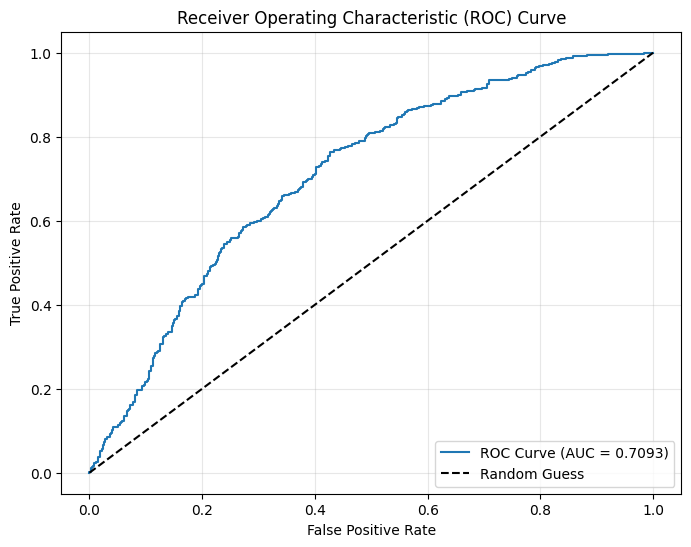

(0.6245269514620304, 0.709316)

In [27]:
evaluate_oneshot_test(trained_simple_model,train_loader,device)
evaluate_oneshot_test(trained_simple_model,test_loader,device)

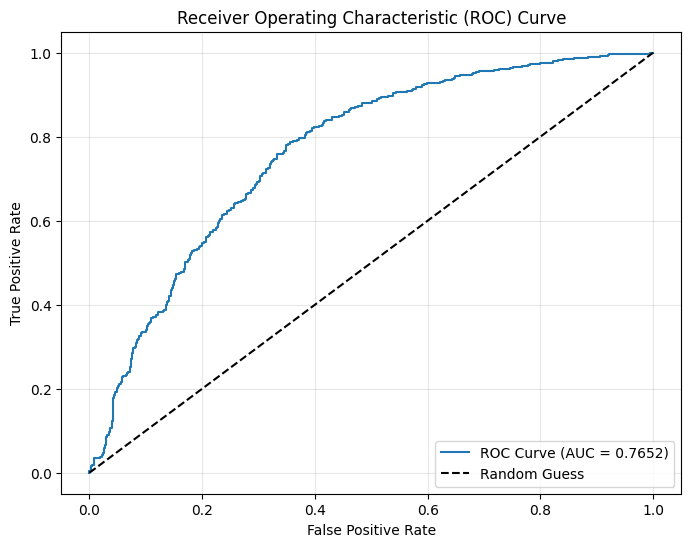

(0.6028738059103489, 0.7652039999999999)

In [28]:
evaluate_oneshot_test(trained_paper_model,test_loader,device)

### Models Comparisions

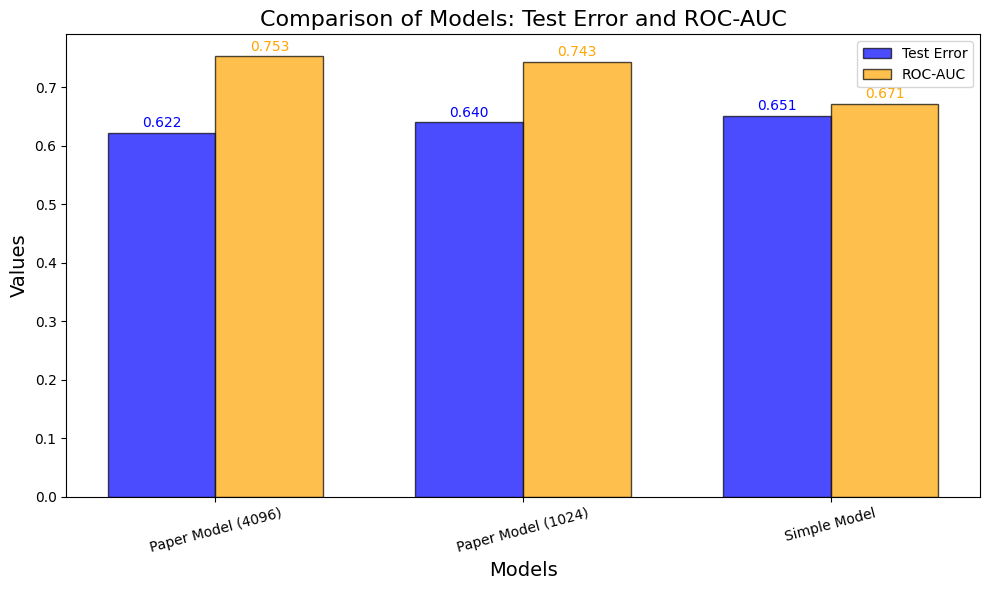

In [58]:
import matplotlib.pyplot as plt

# Data for the models
model_names = ["Paper Model (4096)", "Paper Model (1024)", "Simple Model"]
test_errors = [0.622, 0.640, 0.651]  # Test errors from each model
roc_aucs = [0.753, 0.743, 0.671]     # ROC-AUC scores from each model

# Create the figure
plt.figure(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Bar positions
x = range(len(model_names))

# Plot Test Errors
plt.bar(x, test_errors, width=bar_width, label="Test Error", alpha=0.7, color="blue", edgecolor="black")

# Plot ROC-AUC Scores
plt.bar([p + bar_width for p in x], roc_aucs, width=bar_width, label="ROC-AUC", alpha=0.7, color="orange", edgecolor="black")

# Add labels, title, and legend
plt.title("Comparison of Models: Test Error and ROC-AUC", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], model_names, rotation=15)
plt.legend()

# Annotate the bars
for i, (te, auc) in enumerate(zip(test_errors, roc_aucs)):
    plt.text(i, te + 0.01, f"{te:.3f}", ha="center", fontsize=10, color="blue")
    plt.text(i + bar_width, auc + 0.01, f"{auc:.3f}", ha="center", fontsize=10, color="orange")

# Display the plot
plt.tight_layout()
plt.show()


###Training the Models with 15 Epochs as Max

In [39]:
if __name__ == "__main__":
    # Initialize the model
    # Define device (GPU if available, else CPU)
    MAX_EPOCHS=15
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Update the model to use the GPU
    simple_model = SimplifiedSiameseNetwork().to(device)
    paper_model = PaperSiameseNetwork().to(device)
    paper_model_1024 = Paper_SiameseNetwork_1024_Output().to(device)


    trained_simple_model = train_model(simple_model,train_loader,val_loader,lr=LEARNING_RATE,momentum=MOMENTUM,
                                       weight_decay=WEIGHT_DECAY,max_epochs=MAX_EPOCHS,early_stop_patience=EARLY_STOP_PATIENCE,device=device)

    trained_paper_model = train_model(paper_model,train_loader,val_loader,lr=LEARNING_RATE,momentum=MOMENTUM,
                                       weight_decay=WEIGHT_DECAY,max_epochs=MAX_EPOCHS,early_stop_patience=EARLY_STOP_PATIENCE,device=device)

    trained_1024_paper_model = train_model(paper_model,train_loader,val_loader,lr=LEARNING_RATE,momentum=MOMENTUM,
                                       weight_decay=WEIGHT_DECAY,max_epochs=MAX_EPOCHS,early_stop_patience=EARLY_STOP_PATIENCE,device=device)

Using device: cuda
Epoch [1/15] - Avg Loss: 0.7497, Val Error: 0.7074, LR: 0.00990, Momentum: 0.5000
Epoch [2/15] - Avg Loss: 0.7175, Val Error: 0.6979, LR: 0.00980, Momentum: 0.5267
Epoch [3/15] - Avg Loss: 0.7027, Val Error: 0.7414, LR: 0.00970, Momentum: 0.5533
Epoch [4/15] - Avg Loss: 0.6907, Val Error: 0.6832, LR: 0.00961, Momentum: 0.5800
Epoch [5/15] - Avg Loss: 0.6660, Val Error: 0.6738, LR: 0.00951, Momentum: 0.6067
Epoch [6/15] - Avg Loss: 0.6534, Val Error: 0.6816, LR: 0.00941, Momentum: 0.6333
Epoch [7/15] - Avg Loss: 0.6383, Val Error: 0.7159, LR: 0.00932, Momentum: 0.6600
Epoch [8/15] - Avg Loss: 0.6336, Val Error: 0.6846, LR: 0.00923, Momentum: 0.6867
Epoch [9/15] - Avg Loss: 0.6201, Val Error: 0.6800, LR: 0.00914, Momentum: 0.7133
Epoch [10/15] - Avg Loss: 0.6094, Val Error: 0.6649, LR: 0.00904, Momentum: 0.7400
Epoch [11/15] - Avg Loss: 0.5954, Val Error: 0.6918, LR: 0.00895, Momentum: 0.7667
Epoch [12/15] - Avg Loss: 0.5841, Val Error: 0.6548, LR: 0.00886, Momentum: 0

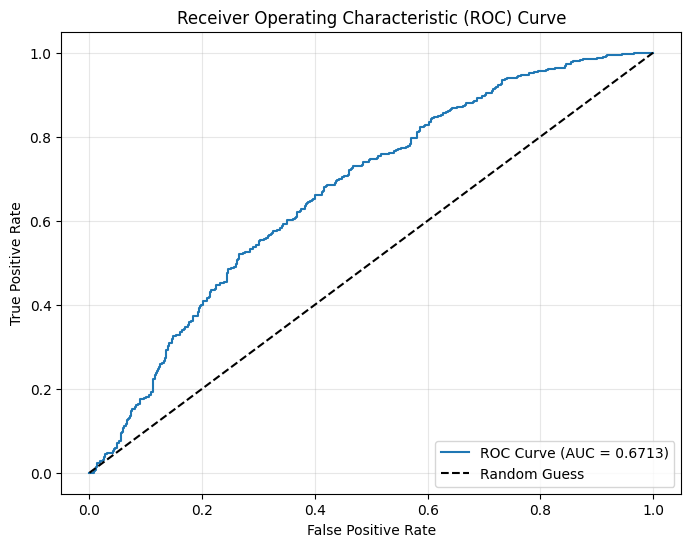

(0.6511467583477497, 0.671284)

In [40]:
evaluate_oneshot_test(trained_simple_model,test_loader,device)

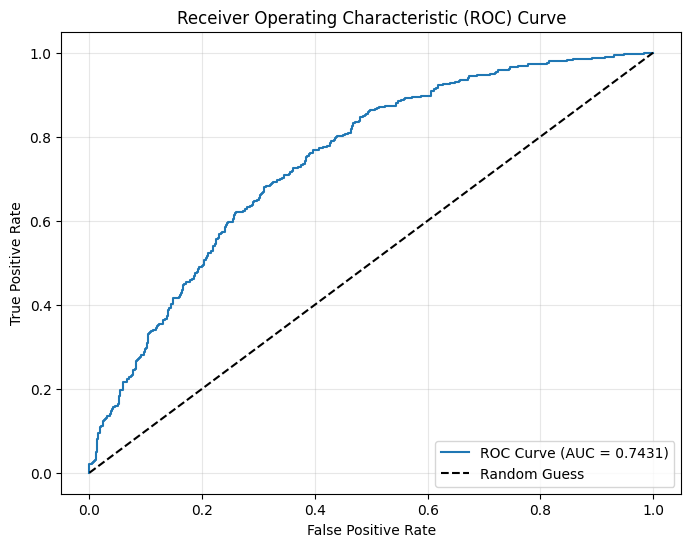

(0.6395253948867321, 0.7431240000000001)

In [42]:
evaluate_oneshot_test(trained_1024_paper_model,test_loader,device)

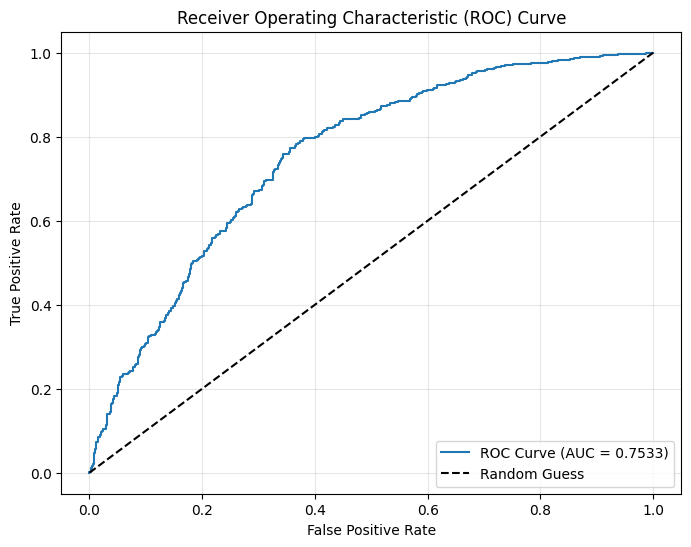

(0.6220698468387127, 0.753268)

In [41]:
evaluate_oneshot_test(trained_paper_model,test_loader,device)

### Models Comparision with 15 Epochs

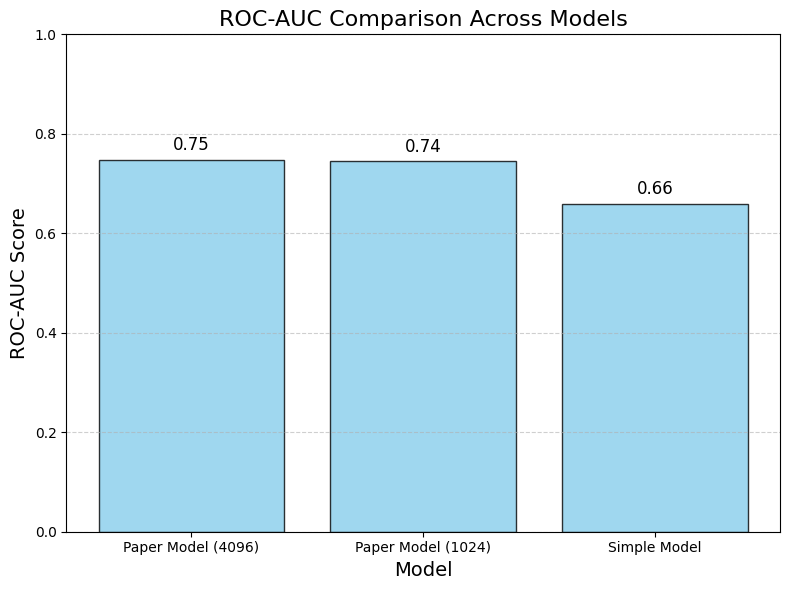

In [63]:
import matplotlib.pyplot as plt

# Initialize lists to store model names and their corresponding ROC-AUC values
model_names = [
    "Paper Model (4096)",
    "Paper Model (1024)",
    "Simple Model"
]
roc_aucs = []

# Evaluate each model and store the ROC-AUC
_, roc_auc_paper = evaluate_oneshot_test(trained_paper_model, test_loader, device)
roc_aucs.append(roc_auc_paper)

_, roc_auc_1024 = evaluate_oneshot_test(trained_1024_paper_model, test_loader, device)
roc_aucs.append(roc_auc_1024)

_, roc_auc_simple = evaluate_oneshot_test(trained_simple_model, test_loader, device)
roc_aucs.append(roc_auc_simple)


# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, roc_aucs, color="skyblue", edgecolor="black", alpha=0.8)

# Set chart properties
plt.title("ROC-AUC Comparison Across Models", fontsize=16)
plt.ylabel("ROC-AUC Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0, 1.0)  # Set y-axis limit from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Annotate the bar chart with the ROC-AUC scores
for i, score in enumerate(roc_aucs):
    plt.text(i, score + 0.02, f"{score:.2f}", ha="center", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()



## GridSearch




In [ ]:
# Define a parameter grid for optimizer, learning rate, momentum, and weight_decay
param_grid = {
    'optimizer_class': [SGD, Adam, RMSprop],
    'lr': [0.01, 0.001],
    'momentum': [0.9, 0.7],  # Only used for SGD and RMSprop
    'weight_decay': [0.001, 0.0005],
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Generate all combinations of hyperparameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_error = float('inf')
best_params = None
best_model_state = None

for params in param_combinations:
    # Skip momentum if using Adam (Adam doesn't use momentum in the same way as SGD and RMSprop)
    if params['optimizer_class'] == Adam and 'momentum' in params:
        del params['momentum']

    print(f"Testing configuration: {params}")

    # Initialize a new model for each parameter set
    model = SiameseNetwork().to(device)

    # Train with the given parameters
    optimizer_params = {k: v for k, v in params.items() if k in ['lr', 'momentum', 'weight_decay']}
    trained_model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer_class=params['optimizer_class'],
        optimizer_params=optimizer_params,
        max_epochs=MAX_EPOCHS,
        early_stop_patience=EARLY_STOP_PATIENCE,
        device=device
    )

    # Evaluate on the validation set
    val_error = evaluate_oneshot(trained_model, val_loader, device)
    print(f"Validation Error: {val_error:.4f}")

    # Check if this is the best so far
    if val_error < best_val_error:
        best_val_error = val_error
        best_params = params
        # Save model state
        best_model_state = deepcopy(trained_model.state_dict())

print("Grid search complete.")
print("Best hyperparameters:", best_params)
print("Best validation error:", best_val_error)

# Re-load the best model
best_model = SiameseNetwork().to(device)
best_model.load_state_dict(best_model_state)

# Evaluate on the test set
test_error = evaluate_oneshot(best_model, test_loader, device)
print(f"Test Error with best model: {test_error:.4f}")


Using device: cuda
Testing configuration: {'optimizer_class': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.001}
Epoch [1/50] - Avg Loss: 0.8102, Val Error: 0.6636, LR: 0.00990, Momentum: 0.5000
Epoch [2/50] - Avg Loss: 0.7165, Val Error: 0.6716, LR: 0.00980, Momentum: 0.5000
Epoch [3/50] - Avg Loss: 0.6634, Val Error: 0.6390, LR: 0.00970, Momentum: 0.5000
Epoch [4/50] - Avg Loss: 0.6147, Val Error: 0.6109, LR: 0.00961, Momentum: 0.5000
Epoch [5/50] - Avg Loss: 0.5511, Val Error: 0.6261, LR: 0.00951, Momentum: 0.5000
Epoch [6/50] - Avg Loss: 0.5154, Val Error: 0.5942, LR: 0.00941, Momentum: 0.5000
Epoch [7/50] - Avg Loss: 0.4999, Val Error: 0.5999, LR: 0.00932, Momentum: 0.5000
Epoch [8/50] - Avg Loss: 0.4561, Val Error: 0.5941, LR: 0.00923, Momentum: 0.5000
Epoch [9/50] - Avg Loss: 0.4528, Val Error: 0.6042, LR: 0.00914, Momentum: 0.5000
Epoch [10/50] - Avg Loss: 0.4176, Val Error: 0.6021, LR: 0.00904, Momentum: 0.5000
Epoch [11/50] - Avg Loss: 0.3719, 

In [ ]:
if __name__ == "__main__":
    # Initialize the model
    # Define device (GPU if available, else CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Update the model to use the GPU
    model = SiameseNetwork().to(device)

    # Train the model
    print("Starting training SGD...")
    trained_model_SGD = train_model(
        model,
        train_loader,
        val_loader
    )
    print("Starting training ADAM...")
    trained_model_ADAM = train_model(
    model,
    train_loader,
    val_loader,
    optimizer_class=Adam,
    optimizer_params={"lr": 0.001, "weight_decay": 0.0005}
)
    print("Starting training RMSprop...")
    trained_model_RMSprop = train_model(
    model,
    train_loader,
    val_loader,
    optimizer_class=RMSprop
)

    print("Trainings completed.")

    # Evaluate the model on the test set
    print("Evaluating on the test set using SGD...")
    test_error = evaluate_oneshot(trained_model_SGD, test_loader,device)
    print(f"Test Error  of SGD: {test_error:.4f}")

    print("Evaluating on the test set using ADAM...")
    test_error = evaluate_oneshot(trained_model_ADAM, test_loader,device)
    print(f"Test Error of ADAM: {test_error:.4f}")

    print("Evaluating on the test set using RMSprop...")
    test_error = evaluate_oneshot(trained_model_RMSprop, test_loader,device)
    print(f"Test Error of RMSprop: {test_error:.4f}")



In [ ]:
evaluate_oneshot_test(trained_model_SGD,train_loader,device)
evaluate_oneshot_test(trained_model_SGD,test_loader,device)

In [ ]:
evaluate_oneshot_test(trained_model_ADAM,train_loader,device)
evaluate_oneshot_test(trained_model_ADAM,test_loader,device)

## Error Analysis

In [54]:
def evaluate_oneshot_test_labels(model, test_loader, device):
    model.eval()
    all_labels = []
    all_scores = []
    all_image_pairs = []

    with torch.no_grad():
        for batch in test_loader:
            img1, img2, labels = batch
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Get predictions
            outputs = model(img1, img2).squeeze()
            scores = outputs.cpu().numpy()
            labels = labels.cpu().numpy()

            # Save labels, scores, and image pairs
            all_labels.extend(labels)
            all_scores.extend(scores)
            all_image_pairs.extend(zip(img1.cpu(), img2.cpu()))

    return all_labels, all_scores, all_image_pairs

def visualize_pair(pair, score, label, prediction_type):
    img1, img2 = pair
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img1.squeeze(), cmap="gray")
    axes[0].set_title("Image 1")
    axes[1].imshow(img2.squeeze(), cmap="gray")
    axes[1].set_title("Image 2")
    plt.suptitle(f"{prediction_type}: True Label={label}, Predicted Score={score:.2f}")
    plt.show()


### 1024 Model

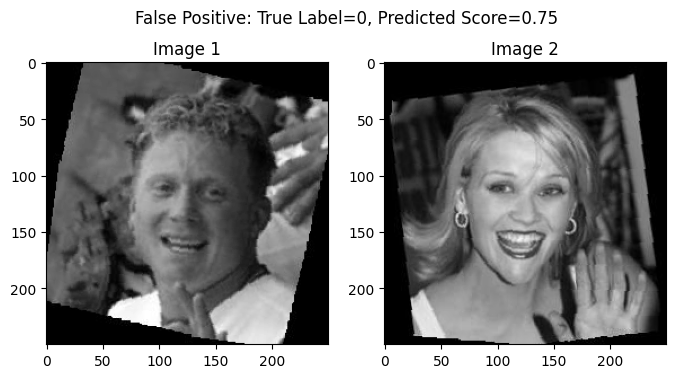

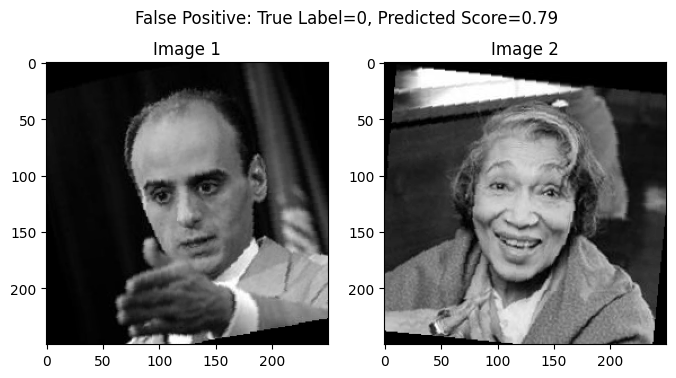

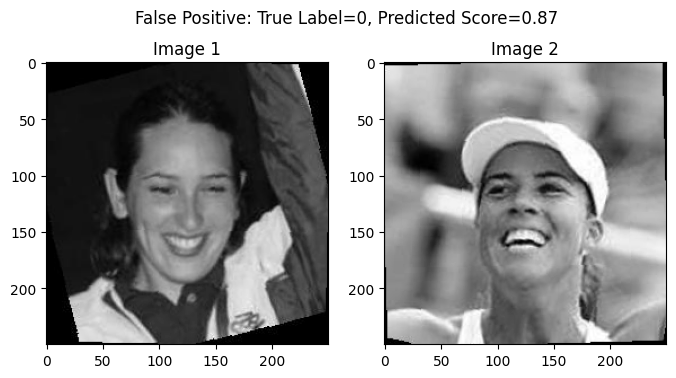

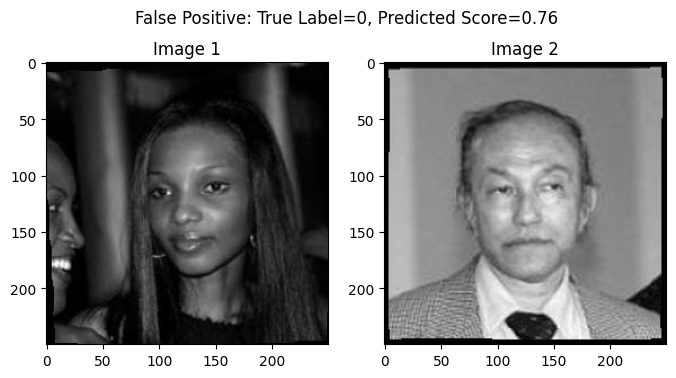

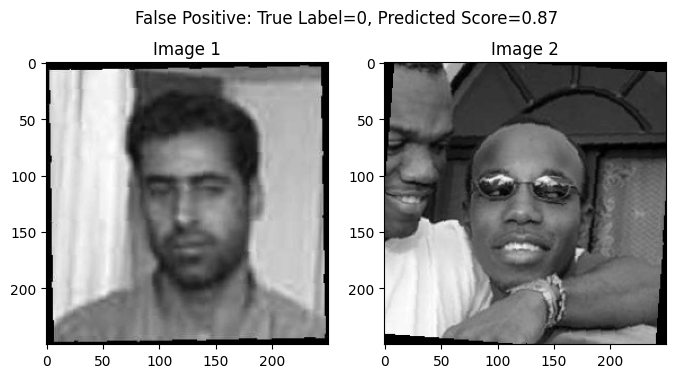

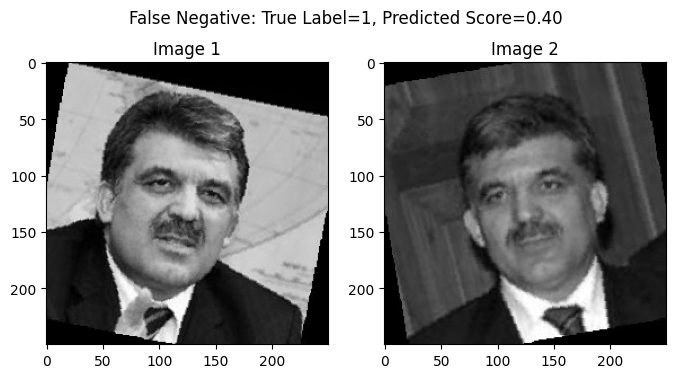

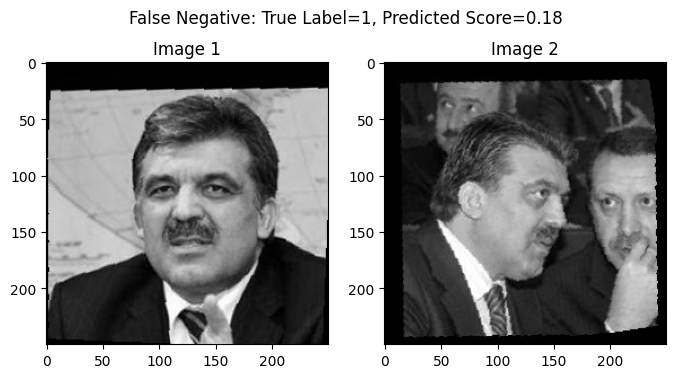

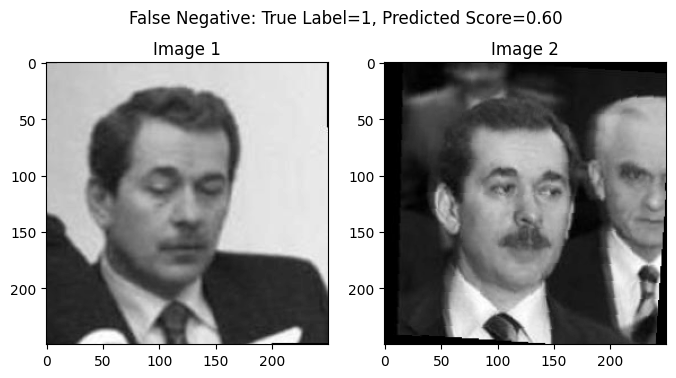

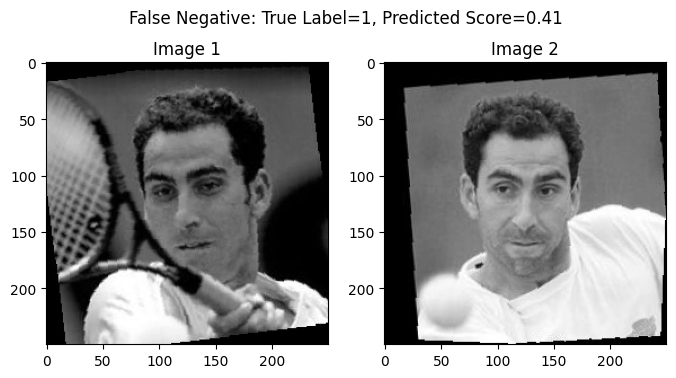

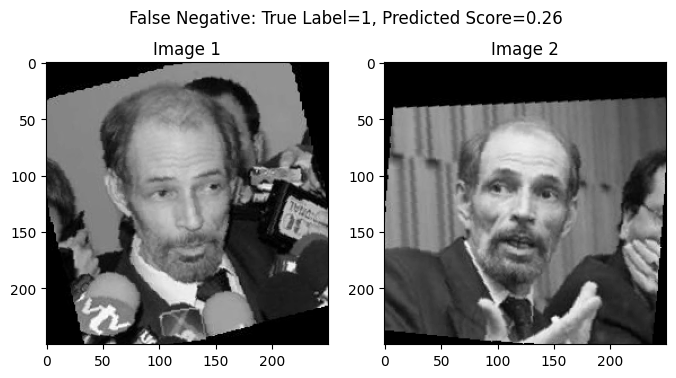

In [57]:
all_labels_1024 ,all_scores_1024 , all_image_pairs_1024 = evaluate_oneshot_test_labels(trained_1024_paper_model,test_loader,device)

threshold = 0.6
false_positives = []
false_negatives = []

for i, (label, score, pair) in enumerate(zip(all_labels_1024, all_scores_1024, all_image_pairs_1024)):
    if label == 0 and score > threshold:  # False Positive
        false_positives.append((pair, label, score))
    elif label == 1 and score < threshold:  # False Negative
        false_negatives.append((pair, label, score))

# Visualize False Positives
for pair, label, score in false_positives[:5]:
    visualize_pair(pair, score, label, "False Positive")

# Visualize False Negatives
for pair, label, score in false_negatives[:5]:
    visualize_pair(pair, score, label, "False Negative")

### Paper Model

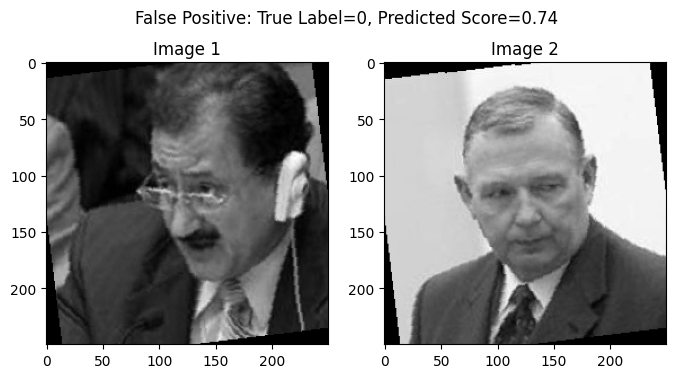

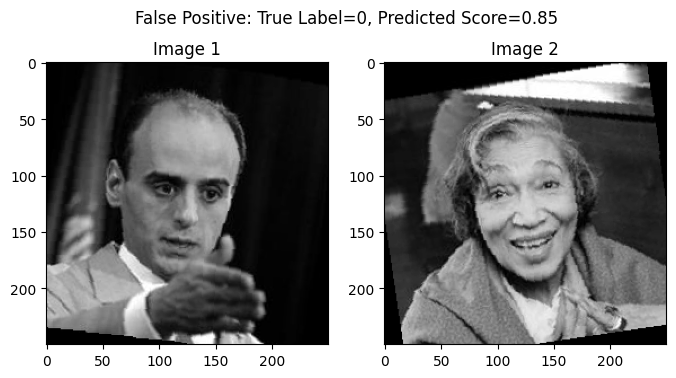

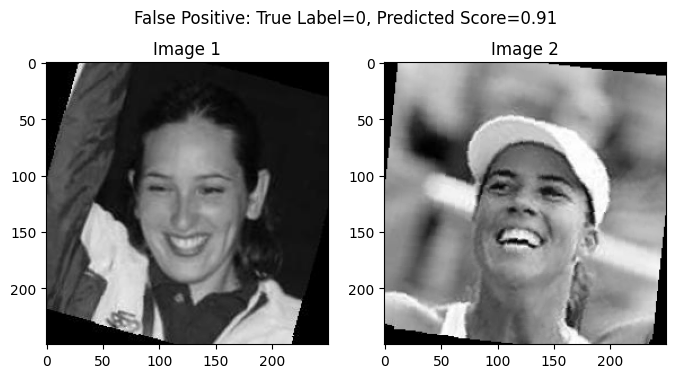

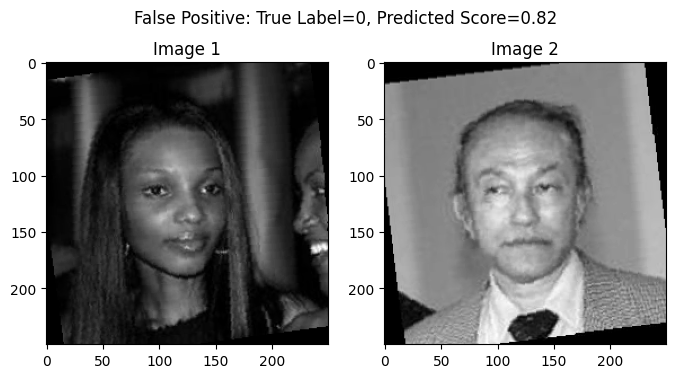

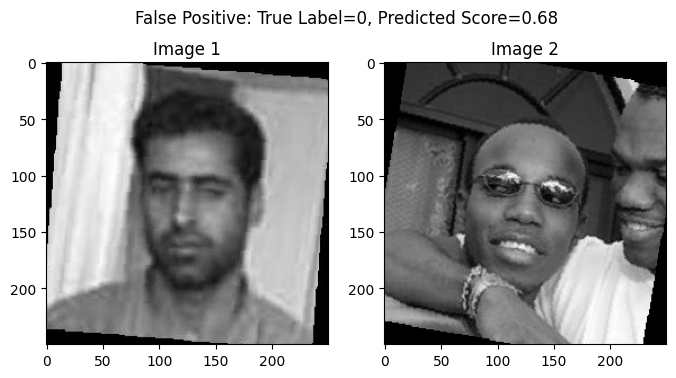

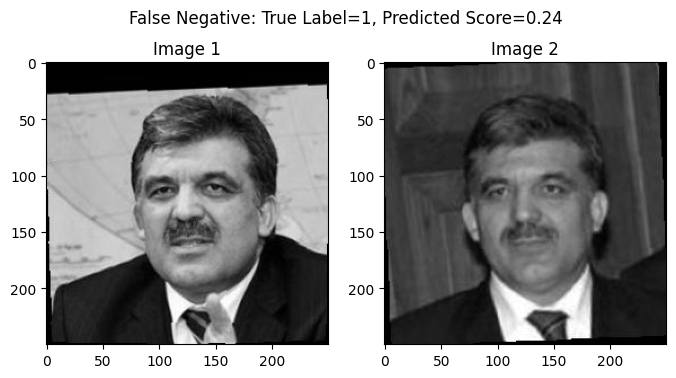

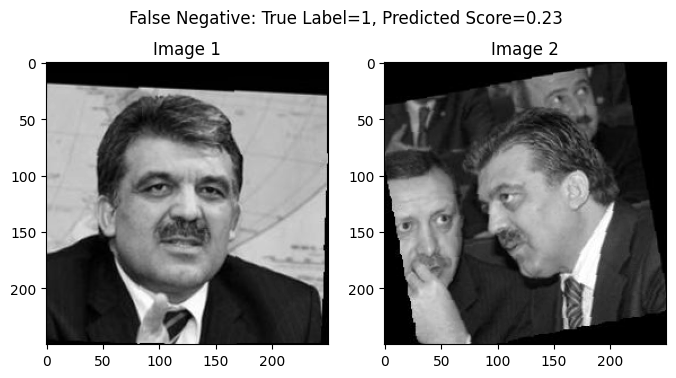

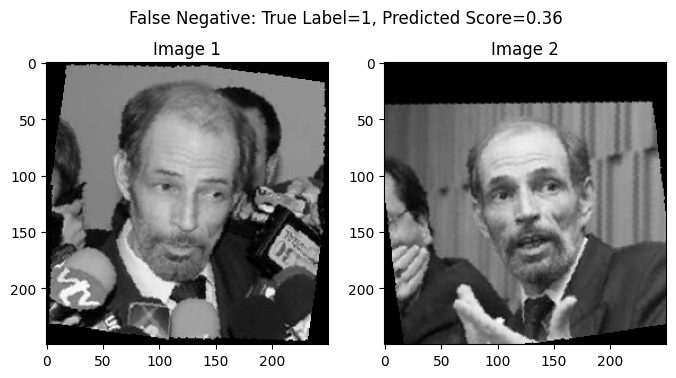

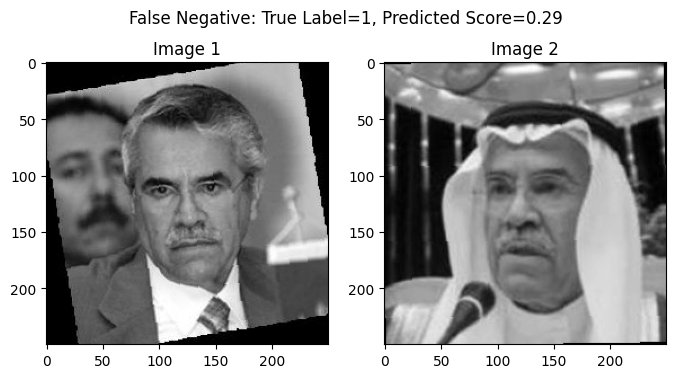

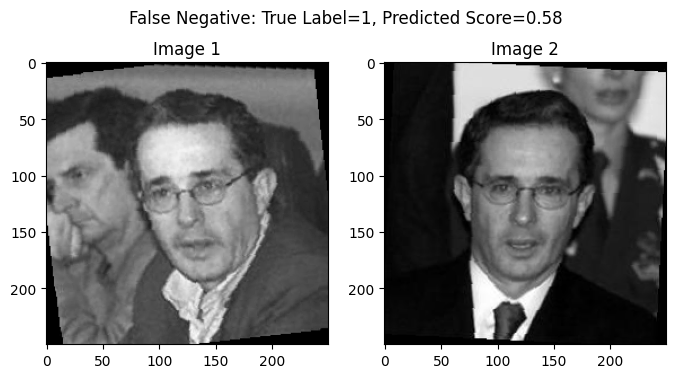

In [55]:
all_labels_paper ,all_scores_paper , all_image_pairs_paper = evaluate_oneshot_test_labels(trained_paper_model,test_loader,device)

threshold = 0.6
false_positives = []
false_negatives = []

for i, (label, score, pair) in enumerate(zip(all_labels_paper, all_scores_paper, all_image_pairs_paper)):
    if label == 0 and score > threshold:  # False Positive
        false_positives.append((pair, label, score))
    elif label == 1 and score < threshold:  # False Negative
        false_negatives.append((pair, label, score))

# Visualize False Positives
for pair, label, score in false_positives[:5]:
    visualize_pair(pair, score, label, "False Positive")

# Visualize False Negatives
for pair, label, score in false_negatives[:5]:
    visualize_pair(pair, score, label, "False Negative")

### Simple Model

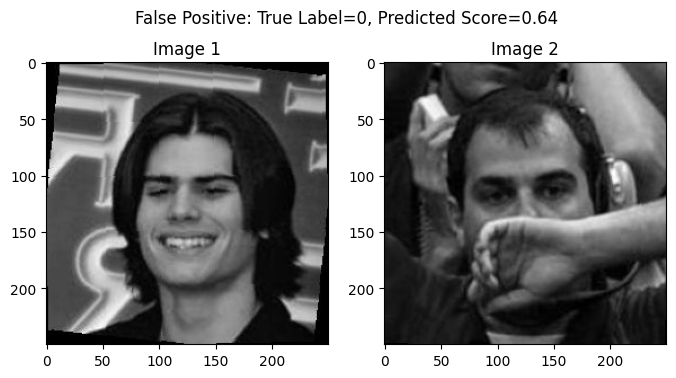

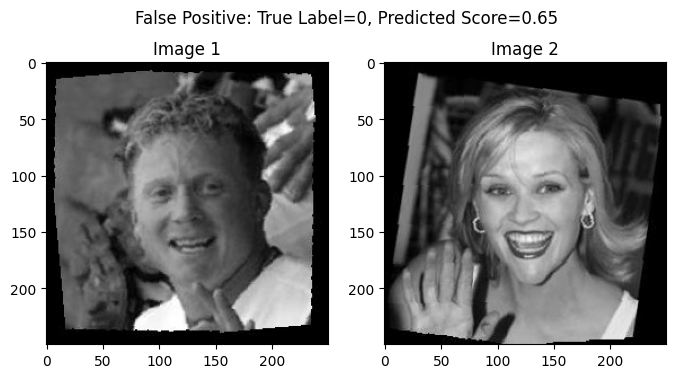

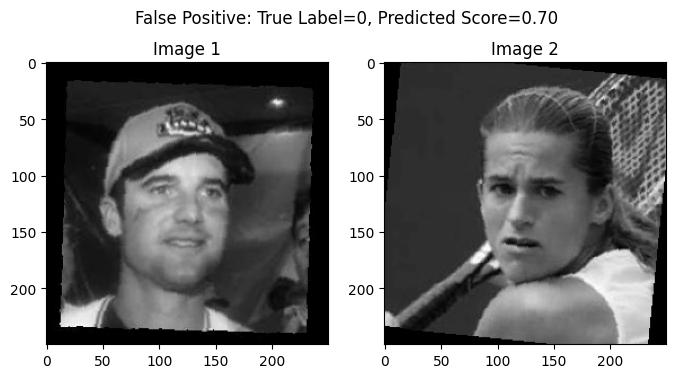

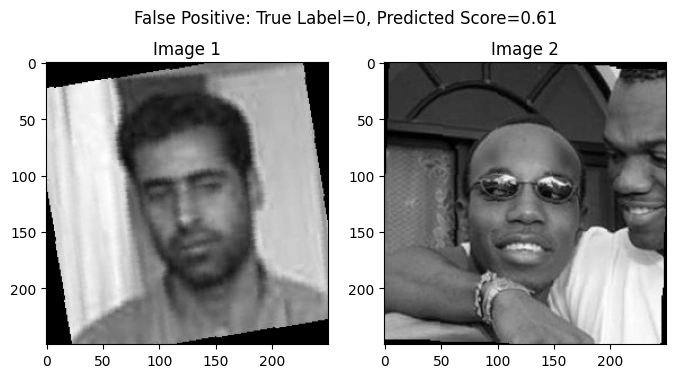

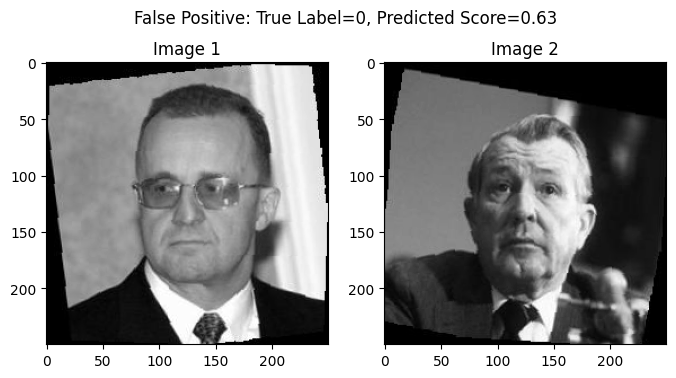

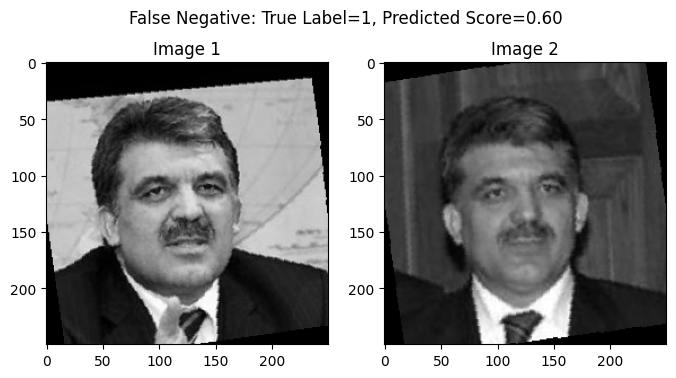

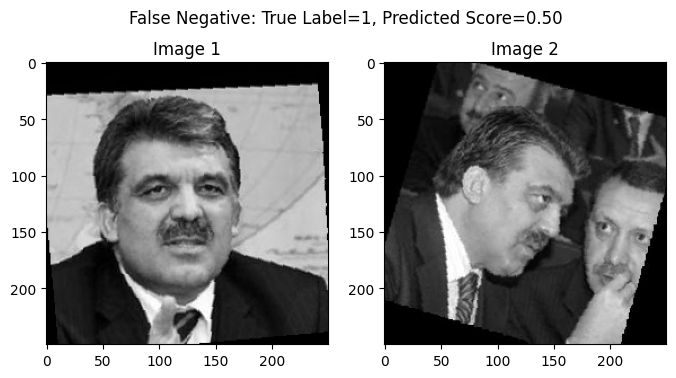

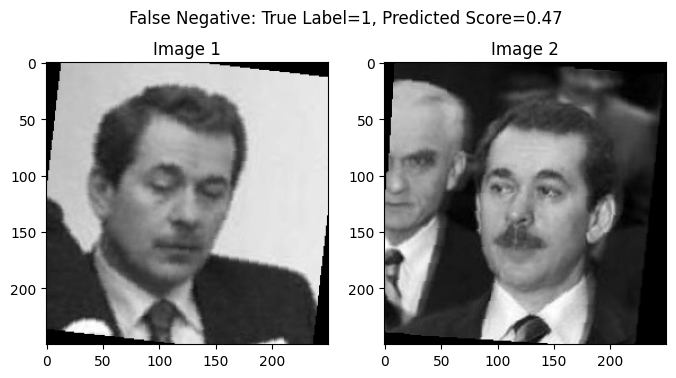

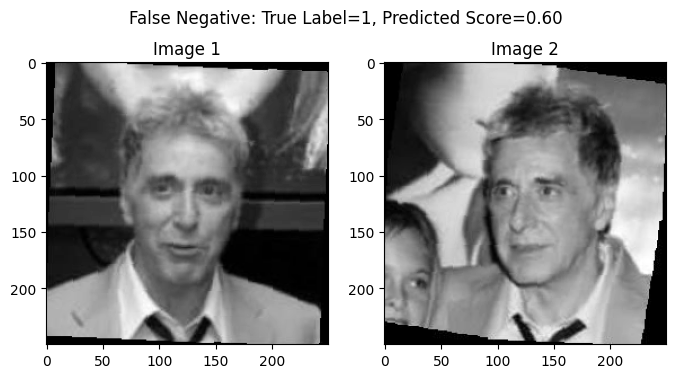

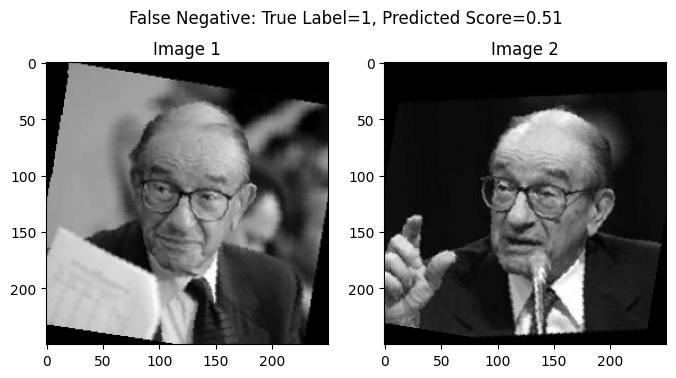

In [56]:
all_labels_simple ,all_scores_simple , all_image_pairs_simple = evaluate_oneshot_test_labels(trained_simple_model,test_loader,device)

threshold = 0.6
false_positives = []
false_negatives = []

for i, (label, score, pair) in enumerate(zip(all_labels_simple, all_scores_simple, all_image_pairs_simple)):
    if label == 0 and score > threshold:  # False Positive
        false_positives.append((pair, label, score))
    elif label == 1 and score < threshold:  # False Negative
        false_negatives.append((pair, label, score))

# Visualize False Positives
for pair, label, score in false_positives[:5]:
    visualize_pair(pair, score, label, "False Positive")

# Visualize False Negatives
for pair, label, score in false_negatives[:5]:
    visualize_pair(pair, score, label, "False Negative")

In [ ]:
evaluate_oneshot_test(trained_model_RMSprop,train_loader,device)
evaluate_oneshot_test(trained_model_RMSprop,test_loader,device)